### Sentiment Analysis
* Sentiment analysis involves determining the sentiment of text.
* In this lab, you will use a hotel review data set that includes reviews and a rating 
 * There are other features that you can ignore, unless you want to use them to improve results
* Your goal is to train a model that can predict the number of stars based on the text
* This is the last programming assignment. We will use similar cleaning and discovery techniques as other assignments
 * ... except we need to add the fun of stop words, stemming / lemmatizing and similar exciting topics.
* Dont forget to save this as a copy in your Google Colab environment



* **Student Name:** Hanh Nguyen
* **Partner Name:** Stephanie Chen 

### Get the data
* Either download the data and store it in your drive or use the Kaggle API to obtain the data from
 * https://www.kaggle.com/datasets/datafiniti/hotel-reviews

In [1]:
import pandas as pd
import sklearn as sk
import math
from google.colab import drive

In [2]:
# Load the dataset 

drive.mount('/content/drive')
path = "/content/drive/Shareddrives/NLP/7282_1.csv"
data = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


### Explore and Clean the Data

In [4]:
data = data.drop_duplicates(subset = ['reviews.text'])

In [5]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
review=pd.DataFrame(data.groupby('reviews.rating').size().sort_values(ascending=False).rename('No of Users').reset_index())
review.head()

,reviews.rating,No of Users
0,5.0,12274
1,4.0,9402
2,3.0,5510
3,1.0,2970
4,2.0,2907


In [7]:
import re
import nltk
import string
import nltk
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from keras.models import Model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from langdetect import detect
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
# Create clean data set with rating and text reviews columns. Drop null
cleanData = data[['reviews.rating', 'reviews.text']]
cleanData = cleanData.dropna()
print(cleanData.isnull().sum())

# Change objects into int/string and lowercase, remove non-letter rows
cleanData['reviews.rating'] = cleanData['reviews.rating'].astype(int)
cleanData['reviews.text'] = cleanData['reviews.text']
cleanData['reviews.text'] = cleanData['reviews.text'].str.lower()
cleanData = cleanData[cleanData['reviews.text'].astype(str).str.contains('[a-zA-Z]', na=False)]

# Remove non-alphabetical/symbol/bad rows
cleanData['reviews.text'].replace(to_replace='[^\w]+', value=' ',inplace=True,regex=True)
cleanData = cleanData[cleanData['reviews.text'] != 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx']
cleanData = cleanData[~cleanData['reviews.text'].str.startswith(' ')]
cleanData = cleanData[cleanData['reviews.text'].astype(str).str.contains('[a-zA-Z]', na=False)]

# Remove non-English rows
cleanData = cleanData[cleanData['reviews.text'].astype(str).apply(detect).eq('en')]

# Set stop words
stop_words = stopwords.words('english')
new_stop = ['10', 'min', 'along', 'etc', 'quite', 'take', 'know', 'hotel', 'lido', 'onto', \
             'way']
stop_words.extend(new_stop)

# Tokenize, make lowercase, remove non english
for i, row in cleanData.iterrows():
    word_tokens = word_tokenize(cleanData['reviews.text'][i].lower())
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    cleanData['reviews.text'][i] = filtered_sentence
stopData = cleanData[cleanData['reviews.text'].astype(str).str.contains('[a-zA-Z]', na=False)]

# Lem words
lemmatizer = WordNetLemmatizer()
lemmedData = stopData
for i, row in stopData.iterrows():
    words = lemmedData['reviews.text'][i]
    lemmedData['reviews.text'][i] = [lemmatizer.lemmatize(word) for word in words]



reviews.rating    0
reviews.text      0
dtype: int64


<ipython-input-8-248a8b2eb1f5>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanData['reviews.text'][i] = filtered_sentence
<ipython-input-8-248a8b2eb1f5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lemmedData['reviews.text'][i] = [lemmatizer.lemmatize(word) for word in words]


In [9]:
joinedData = lemmedData
joinedData['reviews.text'] = [" ".join(x) for x in lemmedData['reviews.text']]

<ipython-input-9-9cc221a7dde3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joinedData['reviews.text'] = [" ".join(x) for x in lemmedData['reviews.text']]


### Train the Model
* Train the model using 90% of the data
* You may choose whichever model technique you choose

In [10]:
X = joinedData['reviews.text']
y = joinedData['reviews.rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =40)

In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  329269


In [12]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

### Test the Model 
* Test the model using the remaining 10% of the data
* The testing results will depend on the model you use
 * If the rating is evaluated as a number, you need to look at values such as mean square error
 * If you are using categories, then you can use accuracy, but you may want to collapse the categories from 1 to 5 to 3 categories such as bad, neutral, and good.

In [13]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.77      0.04      0.07       280
           2       0.00      0.00      0.00       274
           3       0.18      0.02      0.04       542
           4       0.25      0.15      0.19       876
           5       0.44      0.98      0.61      1161
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         9

    accuracy                           0.41      3166
   macro avg       0.15      0.11      0.08      3166
weighted avg       0.33      0.41      0.29      3166



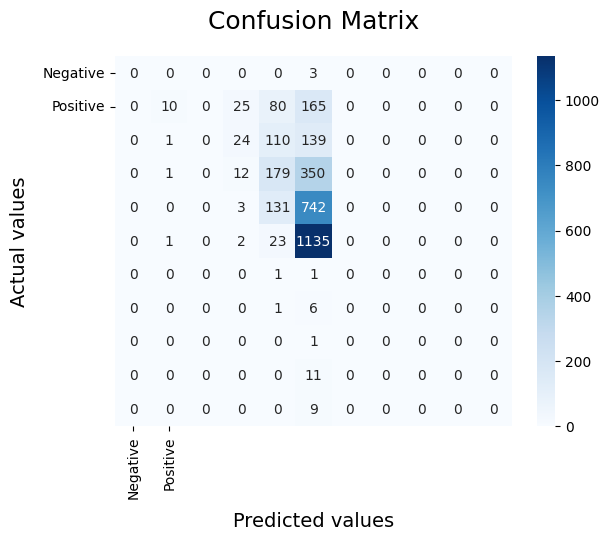

In [14]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.55      0.65      0.60       280
           2       0.35      0.20      0.25       274
           3       0.39      0.30      0.34       542
           4       0.45      0.41      0.43       876
           5       0.62      0.78      0.69      1161
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         9

    accuracy                           0.53      3166
   macro avg       0.31      0.24      0.26      3166
weighted avg       0.50      0.53      0.51      3166



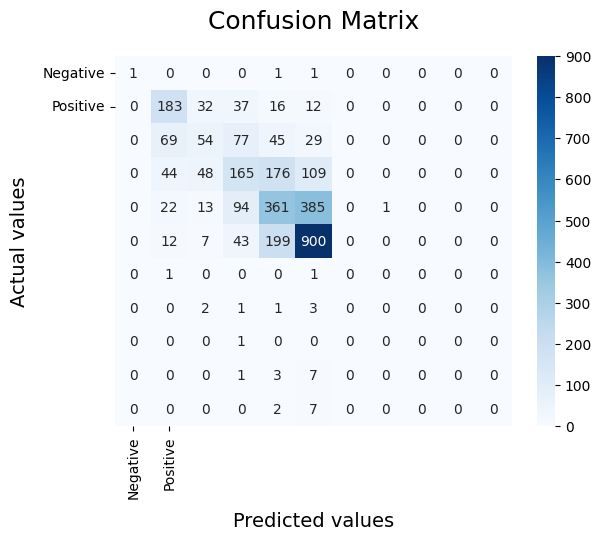

In [15]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

### Provide an explanation of your model and results

In [16]:
print("Bernoulii Naive Bayes f1_score: ", f1_score(y_test, y_pred1, average='micro'))
print("LinearSVC f1_score: ", f1_score(y_test, y_pred2, average='micro'))

Bernoulii Naive Bayes f1_score:  0.4068224889450411
LinearSVC f1_score:  0.525584333543904



* **DO NOT FORGET TO DO THE ANALYSIS PART**

### Explanation: 
- I am evaluating the performance of two different machine learning models, Bernoulli Naive Bayes and LinearSVC, on a test dataset. The purpose of this evaluation is to determine which model performs better at classifying the data into two categories, "Negative" and "Positive". 
- My code calls the "model_Evaluate()" function to calculates the F1-score for each model using the "f1_score" function. The F1-score is a measure of a model's accuracy that takes unti account both precison and recall, with a higher score indicating better performance. 
- Based on my output, the LinearSVC model has a higher F1-score than the Bernoulli Naive Bayes model. Thereforem the LinearSVC model is likely the better performing model for this classification task. However, it is important to note that this evaluation is specific to the test dataset and may not generalize to other datasets. 


### Discuss techniques you could use to improve your model if you had more time

* There are several techniques that I can use to improve the performance of my model. These include feature engineering, hyperparameter tuning, ensemble learning, ... It is important to carefully evaluate the impact of each technique on the specific dataset and task to keep track of the changes to avoid overfitting. 